## Calibration modelling approach

This Jupyter notebook script reproduce part of the results in the manuscript **"Advancing human displacement modelling: A case study of the 2022 summer floods in Pakistan"**, submitted to Earth's Future for peer-review.

This scrpt contains the code to calibrate the best-fit flood depth threshold parameter for the impact functions using the reported displacement number form PDMA (2022) (methods described in the manuscript section 2.4.2). 

The script also includes the estimation of the uncertainty bounds, ultimately producing the plot Figure 2b in the manuscript.

#### Loading the displacement data and the shape file in Sindh Province.

In [1]:
# Load displacement data
from pathlib import Path

import pandas as pd
import geopandas as gpd

from climada.util.constants import DEF_CRS

# Mapping from data columns to exposure regions

# Load the true data
# Create the data frame for the true impact data
DISPLACEMENT_DATA_PATH = Path("../data/displacement_data/PDMA_report_sep_17.xlsx")
displacement_data = pd.read_excel(DISPLACEMENT_DATA_PATH)

# Load the Pakistan shapefile
SHAPEFILE_PATH = Path(
    "../data/boundaries/pak_adm_wfp_20220909_shp/pak_admbnda_adm2_wfp_20220909.shp"
)
shapefile_pakistan = gpd.read_file(SHAPEFILE_PATH).to_crs(DEF_CRS)

# Carve out Sindh provinces
sindh_provinces = shapefile_pakistan.loc[shapefile_pakistan["ADM1_EN"] == "Sindh"]


/Users/kampu/opt/anaconda3/envs/climada_dev/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
displacement_data

,Khairpur,Larkana,Dadu,Umer Kot,Mirpur Khas,Kambar Shahdad Kot,Shaheed Benazir Abad,Sanghar,Kashmore,Jacobabad,...,Badin,Sujawal,Ghotki,Matiari,Hyderabad,Tando Allahyar,Sukkur,Tharparkar,Tando Muhammad Khan,Karachi
0,1218177,1071333,804271,557280,472168,390245,389529,315444,311262,256584,...,96073,95715,84339,51000,33700,27377,19500,19315,15500,508


#### Load the population count data
The constrained population data for the year 2020 is downloaded from WorldPop ([Tatem, 2017](https://www.nature.com/articles/sdata20174)), available at resolution of ~100m. Further information please refer to [https://hub.worldpop.org/geodata/summary?id=50043](https://hub.worldpop.org/geodata/summary?id=50043).

In [3]:
from pathlib import Path

import shapely

from climada.entity import Exposures
from climada.util.constants import DEF_CRS

# Load WorldPop
WORLD_POP_PAK_PATH = Path("../data/population/pak_ppp_2020_UNadj_constrained.tif")

exposure = Exposures.from_raster(
    WORLD_POP_PAK_PATH,
    dst_crs=DEF_CRS,
    geometry=[shapely.union_all(sindh_provinces["geometry"])],
)
exposure.set_geometry_points()
exposure.gdf = exposure.gdf.loc[exposure.gdf["value"] > 0, :]  # Only retain values > 0
exposure.gdf["impf_FL"] = 1

In [4]:
# Assign Admin3 regions
gdf_joined = exposure.gdf.sjoin(sindh_provinces, how="left", predicate="within")

# Merge Karachi regions
adm2 = gdf_joined["ADM2_EN"]
adm2[adm2.str.contains("Karachi")] = "Karachi"
gdf_joined["ADM2_EN"] = adm2

# Set new gdf
exposure.set_gdf(gdf_joined)

#### Load the flood depth data

The flood depth data is calculated following section 2.2 in the manuscript.

In [5]:
from climada.hazard import Hazard
from rasterio.warp import Resampling

HAZ_TYPE ='FL'
HAZ_FILE = '../data/flood_depth/sindh_flooddepth1.tif'

hazard = Hazard.from_raster(HAZ_FILE, 
                            haz_type=HAZ_TYPE,
                            transform=exposure.meta['transform'],
                            height=exposure.meta['height'],
                            width=exposure.meta['width'],
                            resampling=Resampling.bilinear)

#### Run the optimisation

In [6]:
from climada.entity import ImpactFunc, ImpactFuncSet

# define the impact function
def impf_set_step(threshold):
    impf_step = ImpactFunc.from_step_impf(intensity=(0,threshold,10),
                                        haz_type='FL')
    impf_step.name = 'FL sigmoid func'
    impf_step.intensity_unit = 'm'

    impf_set = ImpactFuncSet()
    impf_set.append(impf_step)
    
    return impf_set

In [7]:
df = displacement_data.set_index(pd.Series([1]))
df = df.reindex(sorted(df.columns), axis=1)

In [8]:
df

,Badin,Dadu,Ghotki,Hyderabad,Jacobabad,Jamshoro,Kambar Shahdad Kot,Karachi,Kashmore,Khairpur,...,Sanghar,Shaheed Benazir Abad,Shikarpur,Sujawal,Sukkur,Tando Allahyar,Tando Muhammad Khan,Tharparkar,Thatta,Umer Kot
1,96073,804271,84339,33700,256584,176900,390245,508,311262,1218177,...,315444,389529,120000,95715,19500,27377,15500,19315,137236,557280


In [9]:
# define the cost function
def rmsf2(impact: pd.DataFrame, data: pd.DataFrame):
    return np.exp(
            np.sqrt(
                np.mean(
                    ((np.log((impact + 1) / (data + 1)) ** 2).to_numpy())
                )
            )
    )

In [10]:
# Here runs the optimisation

import numpy as np
import pandas as pd
from functools import partial

from climada.engine import ImpactCalc
from climada.engine import  Impact

from climada.util.calibrate import Input, BayesianOptimizer, BayesianOptimizerController


input = Input(
    hazard=hazard,
    exposure=exposure,
    data=df,
    bounds={"threshold": (0.1, 3)},
    cost_func=rmsf2,
    impact_func_creator=impf_set_step,
    impact_to_dataframe=lambda imp: imp.impact_at_reg(exposure.gdf["ADM2_EN"]),
    impact_calc_kwds={"assign_centroids": False, "save_mat": True},
)


# Create and run the optimizer
opt = BayesianOptimizer(input)
controller = BayesianOptimizerController.from_input(input, sampling_base=32)
bayes_output = opt.run(controller)

#bayes_output_rmsf = opt.run(n_iter=200)
bayes_output.params  # The optimal parameters

{'threshold': 0.6718699790792863}

In [11]:
# Output the results into a dataframe

data = bayes_output.p_space_to_dataframe()
data

,Parameters,Calibration
,threshold,Cost Function
Iteration,,
0,1.309364,5.016370
1,2.188941,7.509003
2,0.100332,5.403324
3,0.976764,4.598538
4,0.525592,4.599320
...,...,...
123,0.671030,4.536164
124,0.671026,4.536167


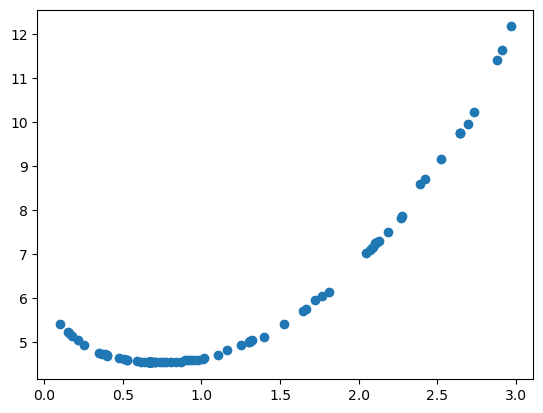

In [12]:
import matplotlib.pyplot as plt

plt.scatter(data['Parameters'], data['Calibration'])
#plt.ylim(0,20)

In [13]:
unc_bounds = data[data['Calibration']['Cost Function'] <= min(data['Calibration']['Cost Function'])+min(data['Calibration']['Cost Function'])*0.05]
unc_bounds.reset_index(drop=True, inplace=True)
unc_bounds

,Parameters,Calibration
,threshold,Cost Function
0,0.976764,4.598538
1,0.525592,4.599320
2,0.367782,4.728706
3,0.640155,4.549127
4,1.102126,4.698336
...,...,...
80,0.671030,4.536164
81,0.671026,4.536167
82,0.671026,4.536167


Text(0, 0.5, 'Displacement ratio (%)')

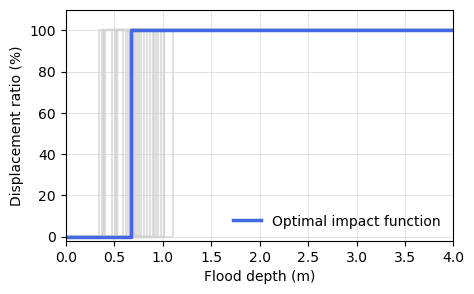

In [14]:
# plot the best-fit function and the uncertainty bound

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from climada.entity import Exposures, ImpactFunc, ImpactFuncSet, ImpfTropCyclone

v_thresh = .1

fig = plt.figure(figsize=(5,3))
plt.grid(visible=True, lw=.5, alpha=.5)

for idx_unc in range(len(unc_bounds)):
    impf = ImpactFunc.from_step_impf(intensity=(0,unc_bounds['Parameters']['threshold'][idx_unc],10),
                                        haz_type='FL')

    plt.plot(impf.intensity, impf.mdd*100, color='lightgrey', lw=1.5, alpha=.7)



impf_opt = ImpactFunc.from_step_impf(intensity=(0,bayes_output.params['threshold'],10),
                                    haz_type='FL')

plt.grid(visible=True, lw=.5, alpha=.5)
#plt.fill_between(impf_opt.intensity, impf_2.mdd*100, impf_4.mdd*100,


plt.plot(impf_opt.intensity, impf_opt.mdd*100, color='royalblue', lw=2.5, label="Optimal impact function")

plt.legend(frameon=False)
plt.xlim(0,4)
plt.xlabel('Flood depth (m)')
plt.ylim(-2,110)
plt.ylabel('Displacement ratio (%)')

#### Uncertainty quantification

Here the uncertainty range of the calibration is estimated.

In [15]:
unc_output = None

for idx_unc in range(len(unc_bounds)):
    unc_params = unc_bounds.iloc[idx_unc, :2].to_frame().T.reset_index(drop=True)
    
    impf_step = impf_set_step(unc_bounds['Parameters']['threshold'][idx_unc])
    
    impact = ImpactCalc(exposure, impf_step, hazard).impact()
    imp_reg = impact.impact_at_reg(agg_regions=exposure.gdf["ADM2_EN"]).reset_index(drop=True)
    
    if unc_output is None:
        unc_output = pd.concat([unc_params, imp_reg], axis=1)
    else:
        unc_output = pd.concat([unc_output, pd.concat([unc_params, imp_reg], axis=1)], axis=0)

unc_output.reset_index(drop=True, inplace=True)

In [16]:
adm2_range_dict = {}

for adm2 in unc_output.columns[2:]:
    adm2_range_dict[adm2] = [unc_output[adm2].min(), unc_output[adm2].max()]
    
adm2_range = pd.DataFrame(adm2_range_dict).T.rename(columns={0:'unc_min', 1:'unc_max'})

In [17]:
impf_opt = impf_set_step(bayes_output.params['threshold'])
impact_opt = ImpactCalc(exposure, impf_opt, hazard).impact()
imp_reg_opt = impact_opt.impact_at_reg(agg_regions=exposure.gdf["ADM2_EN"]).T.rename(columns={1: 'model_opt'})

pdma_report = df.T.rename(columns={1: 'PDMA_report'})

df_plot = pd.concat([pdma_report, imp_reg_opt, adm2_range], axis=1)
df_plot.sort_values(by='PDMA_report', ascending=False, inplace=True)

## Plotting the estimated displacement using the best-fitted function and the uncertainty bounds (Fig. 2b)

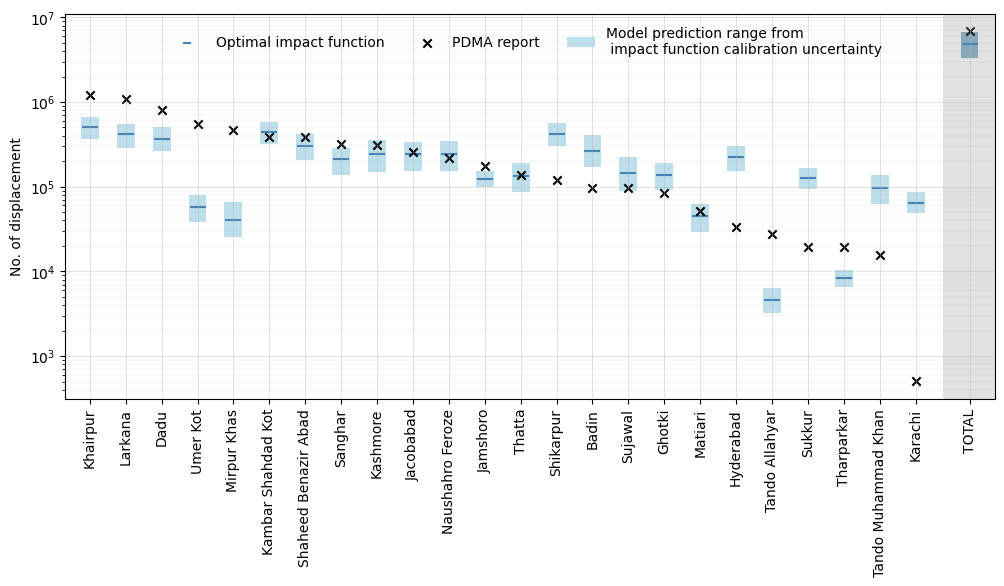

In [18]:
bar_width=0.5

fig = plt.figure(figsize=(12,5))
plt.grid(visible=True, lw=.5, alpha=.5)
plt.grid(which='minor', axis='y',
         lw=.3, alpha=.3)

# plot the range of the step function prediction
plt.bar(np.arange(len(df_plot)), 
        height=df_plot['unc_max']-df_plot['unc_min'],
        bottom=df_plot['unc_min'],
        width=bar_width,
        color='lightblue',
        alpha=0.8,
        label='Model prediction range from\n impact function calibration uncertainty')

plt.scatter(np.arange(len(df_plot)),
            df_plot["model_opt"],
            color='steelblue',
            marker=0,
            label='Optimal impact function')

plt.scatter(np.arange(len(df_plot)),
            df_plot["model_opt"],
            color='steelblue',
            marker=1)


# plot the reported number
plt.scatter(np.arange(len(df_plot)),
            df_plot['PDMA_report'],
            color='k',
            marker='x',
            label='PDMA report')
    
### plot the total value as well
plt.axvspan(23.75, 25.2, color='lightgrey', alpha=0.65, lw=0)
plt.bar(24.5,
        height=df_plot['unc_max'].sum()-df_plot['unc_min'].sum(),
        bottom=df_plot['unc_min'].sum(),
        width=bar_width,
        color='#6090A7',
       alpha=.7)

plt.scatter(24.5,
            df_plot["model_opt"].sum(),
            color='steelblue',
            marker=0)

plt.scatter(24.5,
            df_plot["model_opt"].sum(),
            color='steelblue',
            marker=1)

plt.scatter(24.5,
            df_plot['PDMA_report'].sum(),
            color='k',
            marker='x',
            alpha=.8)
    
#plt.ylim([0, 200000])
plt.yscale("log")
plt.xlim([-0.7, 25.2])
plt.ylabel('No. of displacement')
plt.xticks(np.append(np.arange(len(df_plot)), [24.5]), 
           labels=np.append(df_plot.index.to_numpy(), ['TOTAL']), rotation=90)
#plt.hlines(100, -0.7, 24.7, linestyle='--', lw=.7, color='k')
plt.legend(ncol=3, frameon=False, loc='upper center')